# Credijusto Data Scientist Challenge 💻💰🚀

## Dataset description.

#### 1) Personal [data table]
- **client_id**
    - key to job table
    - key to bank table
    - key to transactional data table
- name
- address
- phone_number
- email_domain
- smoker
- is_married
- car_licence_plate
- age
- number_of_children
- years_of_education
- has_criminal_records

#### 2. Job [data table]
- **client_id**
    - key to personal table
    - key to bank table
    - key to transactional data table
- company
- phone_number
- address
- email_domain
- current_job
- car_licence_plate
- years_in_current_job
- salary

#### 3. Bank [data table]
- **client_id**
    - key to personal table
    - key to job table
    - key to transactional data table
- account_id
    - key to transactional data table
- number_of_credit_cards
- number_logs_per_day
- number_secret_keys_requested
- credit_card_number
- credit_card_expire
- credit_card_provider
- credit_score
- first_credit_card_application_date
- last_credit_card_application_date
- **defaulted_loan**
    - Variable to predit

#### 4. Transactional [data table]
- **transaction_id**
- **account_id**
    - key to bank table
- **client_id**
    - key to personal table
    - key to job table
    - key to bank data table
- duration_minutes
- amount
- type
- date

## Business question

#### Background

1. **Only the training set bank data table has the column defaulted_loan** which has two different outcomes:
    - True
        - Client defaulted (did not pay credit).
        - This is the *Positive class*
    - False
        - Client is OK (did pay credit).
        - This is the *Negative class*
2. You need to make a predictive model to **make predictions of the feature defaulted_loan on the test dataset**.
3. **The evaluation of this challenge relies only on the prediction scores on test dataset**.
    - Choose wisely the evaluation metric for this challenge.


# Problem definition

Lenders provide loans to borrowers in exchange for the promise of repayment with interest. That means the lender only makes profit (interest) if the borrower pays off the loan. However, if he/she doesn’t repay the loan, then the lender loses money.

Therefore the lending industry is based in the answers of two critical questions: 

1) How risky is the borrower?

2) Given the borrower’s risk, should we lend him/her? 

The answer to the first question determines the interest rate the borrower would have. Interest rate measures among other things (such as time value of money) the riskness of the borrower, i.e. the riskier the borrower, the higher the interest rate. With interest rate in mind, we can then determine if the borrower is eligible for the loan. [1]

As stated in the Business question, for our purposes we would only predict the answer of the question 1.



# Set working environment

In [300]:
import pandas as pd
import numpy as np
np.random.seed(1)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
sns.set(style="ticks")
import io
import matplotlib.pyplot as plt
# Un comment the following lines and run to install not common libraries
# !pip install eli5
# !pip install imblearn
import eli5
from imblearn.over_sampling import SMOTE #  Synthetic Minority Oversampling Technique (SMOTE)


# Importing data


In [301]:
data = {
    'train': {
        'personal': pd.read_csv(r'data/client_personal_train.csv'),
        'job': pd.read_csv(r'data/client_job_train.csv'),
        'bank_data': pd.read_csv(r'data/client_bank_data_train.csv'),
        'transactional_data': pd.read_csv(r'data/client_transactional_data_train.csv')      
    },
    'test': {
        'personal': pd.read_csv('data/client_personal_test.csv'),
        'job': pd.read_csv('data/client_job_test.csv'),
        'bank_data': pd.read_csv('data/client_bank_data_test.csv'),
        'transactional_data': pd.read_csv('data/client_transactional_data_test.csv')
    }
}


# Data exploration

## Train Data exploration

### 1 - **Checking datasets dimesions**

In [302]:
[print('Dataset: ' + x + ' | Dataset dimension (rows, cols): ' + str(data['train'][x].shape)) for x in data['train'].keys()]

Dataset: personal | Dataset dimension (rows, cols): (68992, 12)
Dataset: job | Dataset dimension (rows, cols): (68992, 9)
Dataset: bank_data | Dataset dimension (rows, cols): (68992, 12)
Dataset: transactional_data | Dataset dimension (rows, cols): (1517581, 7)


[None, None, None, None]

### 2 - **Checking Row example values**

#### 1) Personal datatable


In [303]:
data['train']['personal'].head()

,is_married,age,name,number_of_children,car_licence_plate,address,has_criminal_records,smoker,years_of_education,phone_number,client_id,email_domain
0,False,31,Joel Herrera,2,8R 3A5NOQ,"0550 Tanya Ferry\nFergusonport, IA 41180",False,True,14,(444)128-8524x089,MUMR3875397452595,yahoo.com
1,False,26,Justin Burgess,3,QIE 2694,"080 Emily Springs Suite 947\nSerranostad, AZ 7...",True,True,17,419-736-1369x7810,LNFC4821269126830,hotmail.com
2,True,29,Samantha Brown,3,6KV R45,"59687 Alexander Walk\nEast David, AZ 21330",False,True,17,1209272743,PIGP5747447418648,gmail.com
3,True,34,Jason Ware,1,YL9 0751,"13474 Flores Mall Suite 952\nNorth Erinfort, N...",False,False,8,(282)819-4842,MDZY2927886938414,gmail.com
4,True,33,Ronald Hoffman,3,LPG 832,"31878 Heather Rapids Suite 933\nNorth Marie, A...",False,True,13,142-489-3506,WETM2827630477279,yahoo.com


**Note**:
* Although it is currently not possible, with the help of an hypothetical additional  "*common_names_dataset*" for female and male individuals, genre information can be extracted from _name_ column.
* Depending on quality of the information contained in the column _address_ , geographical data might be useful for future analysis. For simplicity we won't do it in this notebook.
* *car_licence_plate*, *phone_number* and *email_domain* columns seem to have no immediately useful information.
* *years_of_educaction_ minimum value is -3, which makes no sense. We will later handle this error in the data.

#### 2) Job datatable

In [304]:
data['train']['job'].head()

,years_in_current_job,client_id,salary,phone_number,car_licence_plate,company,email_domain,address,current_job
0,10,LCQQ3834995242554,6626,+1-870-455-1656,AUJ 311,"Smith, Walton and Smith",hotmail.com,Unit 4250 Box 5536\nDPO AE 73809,Retail banker
1,10,BRCD7200842828050,8343,519-526-9913x6540,223R5,"Santos, Wilson and Hampton",yahoo.com,"PSC 4581, Box 0827\nAPO AE 63527",Intelligence analyst
2,15,RSAA3840744969487,6728,5360419904,NXV D21,Adkins-Mcneil,yahoo.com,"1036 Susan Roads\nEast Christophermouth, PA 99481",Multimedia specialist
3,8,KZWB7793929593940,7653,+1-245-845-9876x1778,165 6EL,Aguilar-Paul,hotmail.com,"72107 Hernandez Crossing Suite 699\nKnappstad,...","Development worker, community"
4,11,TETJ4085914615232,8437,739-916-7742,919 8NG,Jensen PLC,hotmail.com,"554 Flores Port\nKevinshire, FL 60356",Investment analyst


**Note**:
* Depending on quality of the information contained in the column _address_ , geographical data might be useful for future analysis.
* *car_licence_plate*, *phone_number* and *email_domain* columns seem to have no immediately useful information.

#### 3) Bank datatable
- Notice that this is the table that contains variable to predict: **defaulted_loan**



In [305]:
data['train']['bank_data'].head()

,number_secret_keys_requested,credit_card_provider,number_logs_per_day,first_credit_card_application_date,last_credit_card_application_date,credit_score,credit_card_number,number_of_credit_cards,account_id,credit_card_expire,client_id,defaulted_loan
0,1,VISA 16 digit,3,2011-10-06 17:58:56,2015-10-31 02:43:10,814,3596118963565100,2,RSGD4569350483260,07/27,ZFUU9069197973171,False
1,1,VISA 16 digit,3,2017-07-18 09:22:24,2017-04-06 23:21:34,835,4036708575533672,2,UNKI9301808547977,04/26,EZZZ2264498911884,False
2,1,JCB 16 digit,2,2017-08-04 06:00:26,2015-10-06 07:11:36,1040,5187829527586586,3,PREO5042440106050,09/24,HTIX3716125146816,False
3,1,Mastercard,3,2017-05-12 21:45:03,2016-01-01 23:51:21,808,4069649723930,2,YFMX9024672103664,04/28,WVDK6716021964941,False
4,1,JCB 16 digit,3,2017-06-24 23:49:50,2018-08-12 03:12:38,523,4511324297912,3,VXZA6446374802774,08/24,GPHF8397791795583,False


**Note**:
* Depending on quality of the information contained in the column _address_ , geographical data might be useful for future analysis.
* *credit_card_number*, *phone_number* and *email_domain* columns seem to have no useful information.


In [306]:
data['train']['bank_data'].describe()

,number_secret_keys_requested,number_logs_per_day,credit_score,credit_card_number,number_of_credit_cards
count,68992.000000,68992.000000,68992.000000,6.899200e+04,68992.000000
mean,1.025322,2.806296,795.185920,3.827469e+17,2.000493
std,0.353449,0.720648,149.745081,1.253543e+18,0.662603
min,0.000000,0.000000,183.000000,6.040030e+10,-1.000000
25%,1.000000,2.000000,694.000000,1.800012e+14,2.000000
50%,1.000000,3.000000,795.000000,3.543128e+15,2.000000
75%,1.000000,3.000000,897.000000,4.933216e+15,2.000000
max,3.000000,6.000000,1413.000000,4.999847e+18,5.000000


#### 4) Bank transactions datatable

In [307]:
data['train']['transactional_data'].head()

,transaction_id,client_id,account_id,date,duration_minutes,amount,type
0,BIGS2655386520335,SQWI6088247113041,UUJG9330648144708,2018-08-21 12:59:47,10,238,Withdrawal
1,BVVC7567878745629,EVEL6951619336672,PZWH9597088886612,2018-07-28 21:21:51,16,387,Withdrawal
2,UUSU6640167293035,MLFH5670327424978,JHZB9470931550704,2018-09-01 00:44:48,12,314,Withdrawal
3,JGXJ2801880132165,VJRK3495233458723,FWHP6221647324126,2018-05-10 07:50:26,16,229,Withdrawal
4,HDQU8860240235988,MFGZ4978234012602,AVPD5598148116569,2018-10-31 23:40:32,7,309,Withdrawal


**Note**:
* *transaction_id* column seems to have no immediately useful information.

In [308]:
data['train']['transactional_data'].describe()

,duration_minutes,amount
count,1.517581e+06,1.517581e+06
mean,1.202201e+01,3.124471e+02
std,3.223771e+00,7.970997e+01
min,-5.000000e+00,-7.500000e+01
25%,1.000000e+01,2.590000e+02
50%,1.200000e+01,3.120000e+02
75%,1.400000e+01,3.660000e+02
max,2.800000e+01,7.210000e+02


### 3 - **Checking Data types**

In [309]:
[print("Datatypes for -" + x + "- dataset are:\n\n" + f"{data['train'][x].dtypes}\n", end = "\n") for x in data['train'].keys()]

Datatypes for -personal- dataset are:

is_married                bool
age                      int64
name                    object
number_of_children       int64
car_licence_plate       object
address                 object
has_criminal_records      bool
smoker                    bool
years_of_education       int64
phone_number            object
client_id               object
email_domain            object
dtype: object

Datatypes for -job- dataset are:

years_in_current_job     int64
client_id               object
salary                   int64
phone_number            object
car_licence_plate       object
company                 object
email_domain            object
address                 object
current_job             object
dtype: object

Datatypes for -bank_data- dataset are:

number_secret_keys_requested           int64
credit_card_provider                  object
number_logs_per_day                    int64
first_credit_card_application_date    object
last_credit_card_applicati

[None, None, None, None]

### 4 - **Checking Null Values**

This is done to identify if it is necessary to later implement data imputing strategies.

In [310]:
[print("Dataset -" + x + "- contains the following number of null values by feature: \n\n" + f"{data['train'][x].isnull().sum()}\n", end = "\n") for x in data['train'].keys()]

Dataset -personal- contains the following number of null values by feature: 

is_married              0
age                     0
name                    0
number_of_children      0
car_licence_plate       0
address                 0
has_criminal_records    0
smoker                  0
years_of_education      0
phone_number            0
client_id               0
email_domain            0
dtype: int64

Dataset -job- contains the following number of null values by feature: 

years_in_current_job    0
client_id               0
salary                  0
phone_number            0
car_licence_plate       0
company                 0
email_domain            0
address                 0
current_job             0
dtype: int64

Dataset -bank_data- contains the following number of null values by feature: 

number_secret_keys_requested          0
credit_card_provider                  0
number_logs_per_day                   0
first_credit_card_application_date    0
last_credit_card_application_date   

[None, None, None, None]

**Note**:
    * No missing values found in the train set.

### 5 - **Checking number of repeated values in ID columns**

This is done to define what kind of merging to do later on the datasets and expect certain behavior derived from it.


In [311]:
for dataset in data["train"]:
    df = data["train"][dataset]
    print("-"*100)
    print("For dataset " + dataset)
    for id_col in df.columns:
        if "_id" in id_col:
            num_uniques = len(df[id_col].unique())
            print("There are "+ str(num_uniques) + " distinct " + id_col)

client_uniques = data["train"]["personal"].client_id.unique()
for dataset in data["train"]:
    if dataset != "personal":
        df = data["train"][dataset].groupby("client_id", as_index = False).count()
        print("-"*50)
        contained_uniques = df.client_id.isin(client_uniques).sum()
        print("Dataset " + dataset +  " has " + str(contained_uniques) + " of " + str(len(client_uniques)) + " client_ids contained in -personal- dataset")


----------------------------------------------------------------------------------------------------
For dataset personal
There are 68992 distinct client_id
----------------------------------------------------------------------------------------------------
For dataset job
There are 68992 distinct client_id
----------------------------------------------------------------------------------------------------
For dataset bank_data
There are 68992 distinct account_id
There are 68992 distinct client_id
----------------------------------------------------------------------------------------------------
For dataset transactional_data
There are 1517581 distinct transaction_id
There are 68992 distinct client_id
There are 68992 distinct account_id
--------------------------------------------------
Dataset job has 68992 of 68992 client_ids contained in -personal- dataset
--------------------------------------------------
Dataset bank_data has 68992 of 68992 client_ids contained in -personal- data

From the previous outputs we can conclude that:
- There are no repeated clients in the personal dataset.
- One client has exactly one job in the job dataset.
- One client has exactly one account in the bank data dataset.
- Some clients may have more than one transaction.

**Note**:

In order to later use the dataset *transactional data* to make one single prediction per client, we have to group the data by client, engineering features from it.



### 6 - **Label stats**
- **defaulted_loan**: if True, it means that the client defaulted the loan. If False, client paid the loan.
- **Our interest is to predict if a credit applicant (client_id) will default the loan.**


In [312]:
data['train']['bank_data']['defaulted_loan'].value_counts()

False    65527
True      3465
Name: defaulted_loan, dtype: int64

In [313]:
100 * np.round(data['train']['bank_data']['defaulted_loan'].value_counts() / data['train']['bank_data'].shape[0], 2)


False    95.0
True      5.0
Name: defaulted_loan, dtype: float64

**Note**:
- Currently, only 5% of the portfilio has defaulted the loan. This indicates that we will have to later manage an unbalanced label dataset to get better expected results.

## Test set exploration


In [314]:
[print('Dataset: ' + x + ' | Dataset dimension (rows, cols): ' + str(data['test'][x].shape)) for x in data['test'].keys()]

Dataset: personal | Dataset dimension (rows, cols): (29568, 12)
Dataset: job | Dataset dimension (rows, cols): (29568, 9)
Dataset: bank_data | Dataset dimension (rows, cols): (29568, 11)
Dataset: transactional_data | Dataset dimension (rows, cols): (649132, 7)


[None, None, None, None]

In [315]:
[print("Dataset -" + x + "- contains the following number of null values by feature: \n\n" + f"{data['test'][x].isnull().sum()}\n", end = "\n") for x in data['test'].keys()]

Dataset -personal- contains the following number of null values by feature: 

is_married              0
age                     0
name                    0
number_of_children      0
car_licence_plate       0
address                 0
has_criminal_records    0
smoker                  0
years_of_education      0
phone_number            0
client_id               0
email_domain            0
dtype: int64

Dataset -job- contains the following number of null values by feature: 

years_in_current_job    0
client_id               0
salary                  0
phone_number            0
car_licence_plate       0
company                 0
email_domain            0
address                 0
current_job             0
dtype: int64

Dataset -bank_data- contains the following number of null values by feature: 

number_secret_keys_requested          0
credit_card_provider                  0
number_logs_per_day                   0
first_credit_card_application_date    0
last_credit_card_application_date   

[None, None, None, None]

**Note**:
- No missing values found in the train set.

For simplicity, we will assume:
* Test set comes from the same distribution as train set (therefore the same distribution of dev set).
* Test set does not contain values not contained in the train set for categorical one-hot encoded features (as this would require to handle this exceptions by replacing those values, droping rows with those values or redefining the feature encoding).

# Data wrangling and feature extraction for Exploratory Data Analysis (EDA)

The goal of this section is to preprocess data to make EDA reveal clearer patterns more easily.

We must always preprocess the train data and the test in the same way to then be able to use the same model to make predictions on both.

**Note**:

Feature extraction is only one of a series of iterative trial and error steps in the machine learning cycle. This is only a first approach.

## Replacing negative *years_of_education* values with 0

As we noticed earlier, the years_of_education_column had negative values. We fix it here by replacing negative values with 0 values.

In [316]:
data["train"]["personal"].loc[data["train"]["personal"].years_of_education < 0, "years_of_education"] = 0
data["test"]["personal"].loc[data["test"]["personal"].years_of_education < 0, "years_of_education"] = 0

## Dropping not useful columns from datasets

As mentioned on the Train Data Exploration section, we may remove the following unuseful feature columns from datasets:
* name
* address
* car_licence_plate
* phone_number
* email_domain 
* credit_card_number

In [317]:
columns_to_drop = ["car_licence_plate", "phone_number", "email_domain", "name", "address", 
                   "credit_card_number", "credit_card_number"]

for dataset in data["train"]:
    data["train"][dataset] = data["train"][dataset].drop([columname for columname in data["train"][dataset].columns
                                 if columname in columns_to_drop], axis = 1)
    print("* " + dataset + " training dataset " + " columns:")
    print(data["train"][dataset].columns.values, end = "\n\n") # Uncomment this line to validate if the operation is succesful

for dataset in data["test"]:
    data["test"][dataset] = data["test"][dataset].drop([columname for columname in data["test"][dataset].columns 
                                 if columname in columns_to_drop], axis = 1)


* personal training dataset  columns:
['is_married' 'age' 'number_of_children' 'has_criminal_records' 'smoker'
 'years_of_education' 'client_id']

* job training dataset  columns:
['years_in_current_job' 'client_id' 'salary' 'company' 'current_job']

* bank_data training dataset  columns:
['number_secret_keys_requested' 'credit_card_provider'
 'number_logs_per_day' 'first_credit_card_application_date'
 'last_credit_card_application_date' 'credit_score'
 'number_of_credit_cards' 'account_id' 'credit_card_expire' 'client_id'
 'defaulted_loan']

* transactional_data training dataset  columns:
['transaction_id' 'client_id' 'account_id' 'date' 'duration_minutes'
 'amount' 'type']



## Converting date columns to datetime type

The following columns are currently of type "object", they should be of type "datetime":
* credit_card_expire (from bank_data dataset)
* first_credit_card_application_date (from bank_data dataset)
* last_credit_card_application_date (from bank_data dataset)
* date (from transactional_data dataset)

In [318]:
for dataset in ["train", "test"]:
    data[dataset]["bank_data"].credit_card_expire = data[dataset]["bank_data"].credit_card_expire.apply(lambda x: pd.to_datetime(r"01/" +x ))
    data[dataset]["bank_data"].first_credit_card_application_date = data[dataset]["bank_data"].first_credit_card_application_date.apply(pd.to_datetime, format="%Y-%m-%d %H:%M:%S")
    data[dataset]["bank_data"].last_credit_card_application_date = data[dataset]["bank_data"].last_credit_card_application_date.apply(pd.to_datetime, format="%Y-%m-%d %H:%M:%S")
    data[dataset]["transactional_data"].date = data[dataset]["transactional_data"].date.apply(pd.to_datetime, format="%Y-%m-%d %H:%M:%S")


Showing column's successful type transformation:

In [319]:
data["train"]["bank_data"][["credit_card_expire", "first_credit_card_application_date", 
                            "last_credit_card_application_date"]].dtypes

credit_card_expire                    datetime64[ns]
first_credit_card_application_date    datetime64[ns]
last_credit_card_application_date     datetime64[ns]
dtype: object

In [320]:
data["train"]["transactional_data"][["date"]].dtypes

date    datetime64[ns]
dtype: object

## Generating *transactional_data* dataset grouped by _client_id_

In [321]:
for dataset in ["train", "test"]:
    df = data[dataset]["transactional_data"]
    # Defining new dataset with a single column of unique client IDs
    data[dataset]["transactional_data_gr"] = pd.DataFrame(pd.Series(df.client_id.unique()), columns = ["client_id"])
    # Filtering transactional_data dataset for each transaction type to calculate aggregation metrics on it
    for transaction_type in df.type.unique():
        temp = df[df.type == transaction_type]
        # Calculating aggregation metrics
        temp = temp.groupby(["client_id"]).agg({"client_id": "count", "amount": ["mean", "sum"], "duration_minutes": "mean", "date": ["min", "max"]})
        temp = temp.rename(columns = {"client_id": "num_transactions"})
        temp.columns = [(transaction_type.lower() + "_" + col[0] + "_" + col[1]) for col in temp.columns] # Renaming columns by transaction type
        temp = temp.reset_index()
        data[dataset]["transactional_data_gr"] = data[dataset]["transactional_data_gr"].merge(temp, on = "client_id")
    # Making sure all client_id rows are unique
    assert len(data[dataset]["transactional_data_gr"]) == len(data[dataset]["transactional_data_gr"].client_id.unique())

print("The transactional_data_gr dataset contains the following columns generated by grouping by client_id: \n ")
for col in data["train"]["transactional_data_gr"].columns:
    print("* " + col)


The transactional_data_gr dataset contains the following columns generated by grouping by client_id: 
 
* client_id
* withdrawal_num_transactions_count
* withdrawal_amount_mean
* withdrawal_amount_sum
* withdrawal_duration_minutes_mean
* withdrawal_date_min
* withdrawal_date_max
* deposit_num_transactions_count
* deposit_amount_mean
* deposit_amount_sum
* deposit_duration_minutes_mean
* deposit_date_min
* deposit_date_max


The feature-engineered columns generated so far are for each transaction type:

* number of transactions
* mean and total sum of amounts
* mean duration (in minutes)
* max and min transaction dates

Showing the resulting grouped dataset:

In [322]:
data["train"]["transactional_data_gr"].head()

,client_id,withdrawal_num_transactions_count,withdrawal_amount_mean,withdrawal_amount_sum,withdrawal_duration_minutes_mean,withdrawal_date_min,withdrawal_date_max,deposit_num_transactions_count,deposit_amount_mean,deposit_amount_sum,deposit_duration_minutes_mean,deposit_date_min,deposit_date_max
0,SQWI6088247113041,16,272.812500,4365,11.812500,2018-02-07 02:55:08,2018-12-26 04:26:36,11,304.363636,3348,12.454545,2018-01-14 10:38:35,2018-10-17 13:25:52
1,EVEL6951619336672,20,323.300000,6466,12.300000,2018-02-20 03:57:58,2018-12-17 05:28:46,11,279.636364,3076,13.545455,2018-01-15 19:35:45,2018-12-19 13:54:34
2,MLFH5670327424978,15,322.000000,4830,12.133333,2018-01-25 18:07:55,2018-12-29 23:21:53,8,298.625000,2389,10.875000,2018-02-11 02:15:42,2019-01-04 11:27:07
3,VJRK3495233458723,27,321.518519,8681,12.000000,2018-01-09 00:09:17,2018-12-31 23:13:15,12,285.000000,3420,10.333333,2018-01-09 16:54:29,2018-12-24 16:15:12
4,MFGZ4978234012602,25,310.840000,7771,11.800000,2018-01-26 17:26:30,2019-01-04 05:08:41,14,297.071429,4159,13.142857,2018-01-08 08:54:44,2018-11-13 16:28:25


The resulting grouped dataset has data types:

In [323]:
data["train"]["transactional_data_gr"].dtypes

client_id                                    object
withdrawal_num_transactions_count             int64
withdrawal_amount_mean                      float64
withdrawal_amount_sum                         int64
withdrawal_duration_minutes_mean            float64
withdrawal_date_min                  datetime64[ns]
withdrawal_date_max                  datetime64[ns]
deposit_num_transactions_count                int64
deposit_amount_mean                         float64
deposit_amount_sum                            int64
deposit_duration_minutes_mean               float64
deposit_date_min                     datetime64[ns]
deposit_date_max                     datetime64[ns]
dtype: object

## Merging datasets into single train and test dataframes

In [324]:
for d_set in ["train", "test"]:    
    data[d_set]["merged_"+d_set] = data[d_set]['personal'].merge(data[d_set]['job'], on = "client_id", how = "left")
    data[d_set]["merged_"+d_set] = data[d_set]["merged_"+d_set].merge(data[d_set]['bank_data'], on = "client_id", how = "left")
    data[d_set]["merged_"+d_set] = data[d_set]["merged_"+d_set].merge(data[d_set]['transactional_data_gr'], on = "client_id", how = "left")
    # Droping ID columns except client_id
    data[d_set]["merged_"+d_set] = data[d_set]["merged_"+d_set].drop(["account_id"], axis = 1)

print("The final " + str(len(data["train"]["merged_train"].columns)) + " trainset columns are: \n\n " +   str(data["train"]["merged_train"].columns))

The final 32 trainset columns are: 

 Index(['is_married', 'age', 'number_of_children', 'has_criminal_records',
       'smoker', 'years_of_education', 'client_id', 'years_in_current_job',
       'salary', 'company', 'current_job', 'number_secret_keys_requested',
       'credit_card_provider', 'number_logs_per_day',
       'first_credit_card_application_date',
       'last_credit_card_application_date', 'credit_score',
       'number_of_credit_cards', 'credit_card_expire', 'defaulted_loan',
       'withdrawal_num_transactions_count', 'withdrawal_amount_mean',
       'withdrawal_amount_sum', 'withdrawal_duration_minutes_mean',
       'withdrawal_date_min', 'withdrawal_date_max',
       'deposit_num_transactions_count', 'deposit_amount_mean',
       'deposit_amount_sum', 'deposit_duration_minutes_mean',
       'deposit_date_min', 'deposit_date_max'],
      dtype='object')


In [325]:
data["train"]["merged_train"].head()

,is_married,age,number_of_children,has_criminal_records,smoker,years_of_education,client_id,years_in_current_job,salary,company,...,withdrawal_amount_sum,withdrawal_duration_minutes_mean,withdrawal_date_min,withdrawal_date_max,deposit_num_transactions_count,deposit_amount_mean,deposit_amount_sum,deposit_duration_minutes_mean,deposit_date_min,deposit_date_max
0,False,31,2,False,True,14,MUMR3875397452595,10,9383,"Williams, Bailey and Smith",...,1981.0,13.666667,2018-02-06 07:26:03,2018-12-20 11:54:47,1.0,369.000000,369.0,11.000000,2018-08-05 15:35:14,2018-08-05 15:35:14
1,False,26,3,True,True,17,LNFC4821269126830,8,5205,"Kim, Salas and Snyder",...,9341.0,11.655172,2018-01-30 22:33:51,2018-12-19 12:56:47,12.0,324.166667,3890.0,11.583333,2018-02-15 20:13:32,2018-12-24 22:08:13
2,True,29,3,False,True,17,PIGP5747447418648,15,10431,Coleman LLC,...,5781.0,13.555556,2018-04-08 10:49:24,2018-12-31 09:00:30,7.0,297.428571,2082.0,13.857143,2018-03-05 06:57:03,2018-12-07 07:20:14
3,True,34,1,False,False,8,MDZY2927886938414,9,8779,"Hogan, Trujillo and Hall",...,5393.0,12.529412,2018-01-24 17:03:46,2019-01-03 16:36:42,6.0,392.500000,2355.0,13.500000,2018-01-26 20:52:54,2018-11-26 08:12:05
4,True,33,3,False,True,13,WETM2827630477279,14,5747,Clay Inc,...,3371.0,11.727273,2018-01-30 06:56:41,2018-12-25 12:46:04,6.0,301.833333,1811.0,12.666667,2018-03-17 14:15:40,2018-12-08 06:15:37


## Further feature engineering

We may perform further feature engineering by defining the next columns:

* transaction_days_range : Range of days between first and last transaction (float32).
* first_transaction_month : Month of first transaction (str).
* first_transaction_year : Year of first transaction (str).
* monthly_avg_withdrawals : Monthly average withdrawal number (float32).
* monthly_avg_deposits : Monthly average deposit number (float32).
* monthly_avg_w_amount : Monthly average withdrawal amount (float32).
* monthly_avg_d_amount : Monthly average deposit amount (float32).
* first_cc_app_month : Month of first credit card application date (str).
* first_cc_app_year : Year of first credit card application date (str).
* cc_expire_month : Month of credit card expire date (str).
* cc_expire_year : Year of credit card expire date (str).

In [326]:
def feat_eng(df):
    df["first_transaction"] = df.apply(lambda x: max(x.withdrawal_date_min, x.deposit_date_min), axis = 1)
    df["last_transaction"] = df.apply(lambda x: min(x.withdrawal_date_max, x.deposit_date_max), axis = 1)
    df["transaction_days_range"] = df.apply(lambda x: (x.last_transaction - x.first_transaction).days, axis = 1)
    df["transaction_days_range"] = df.apply(lambda x: max(x.transaction_days_range, 1), axis = 1)
    df["first_transaction_month"] = df.apply(lambda x: str(min(x.withdrawal_date_min, x.deposit_date_min).month), axis = 1)
    df["first_transaction_year"] = df.apply(lambda x: str(min(x.withdrawal_date_min, x.deposit_date_min).year), axis = 1)
    df["monthly_avg_withdrawals"] = df.withdrawal_num_transactions_count/(df.transaction_days_range.apply(lambda x: x/30))
    df["monthly_avg_deposits"] = df.deposit_num_transactions_count/(df.transaction_days_range.apply(lambda x: x/30))
    df["monthly_avg_w_amount"] = df.withdrawal_amount_sum/(df.transaction_days_range.apply(lambda x: x/30))
    df["monthly_avg_d_amount"] = df.deposit_amount_sum/(df.transaction_days_range.apply(lambda x: x/30))
    df["first_cc_app_month"] =  df.first_credit_card_application_date.apply(lambda x: str(x.month))
    df["first_cc_app_year"] = df.first_credit_card_application_date.apply(lambda x: str(x.year))
    df["cc_expire_month"] = df.credit_card_expire.apply(lambda x: str(x.month))
    df["cc_expire_year"] = df.credit_card_expire.apply(lambda x: str(x.year))
    return df

for d_set in ["train", "test"]:    
    data[d_set]["merged_"+d_set] = feat_eng(data[d_set]["merged_"+d_set])


It is necessary to specifically handle missing values where clients may have no transactions by filling those values with 0 to avoid future exceptions.

In [327]:
handle_cols = ["first_transaction", 
"last_transaction", 
"transaction_days_range", 
"transaction_days_range", 
"first_transaction_month", 
"first_transaction_year", 
"monthly_avg_withdrawals", 
"monthly_avg_deposits", 
"monthly_avg_w_amount", 
"monthly_avg_d_amount", 
"first_cc_app_month", 
"first_cc_app_year", 
"cc_expire_month", 
"cc_expire_year",
"withdrawal_num_transactions_count",
"withdrawal_amount_mean",
"withdrawal_duration_minutes_mean",
"deposit_num_transactions_count",
"deposit_amount_mean",
"deposit_duration_minutes_mean"]

for d_set in ["train", "test"]:    
    data[d_set]["merged_"+d_set][handle_cols] = data[d_set]["merged_"+d_set][handle_cols].fillna(0)


## Obtaining the final pre-EDA dataset 

We can now finally let's drop the following (not useful anymore) columns:

* first_transaction
* last_transaction
* withdrawal_date_min
* withdrawal_date_max
* deposit_date_min
* deposit_date_max
* first_credit_card_application_date
* last_credit_card_application_date
* credit_card_expire

In [328]:
columns_to_drop = ["first_transaction",
                   "last_transaction", 
                   "withdrawal_date_min", 
                    "withdrawal_date_max",
                    "deposit_date_min",
                    "first_credit_card_application_date",
                    "last_credit_card_application_date",
                    "deposit_date_min", 
                    "deposit_date_max", 
                    "credit_card_expire"]

data["train"]["merged_train"] = data["train"]["merged_train"].drop(columns_to_drop, axis = 1)
data["test"]["merged_test"] = data["test"]["merged_test"].drop(columns_to_drop, axis = 1)


We obtain the following resulting merged dataset:

In [329]:
data["train"]["merged_train"].head()

,is_married,age,number_of_children,has_criminal_records,smoker,years_of_education,client_id,years_in_current_job,salary,company,...,first_transaction_month,first_transaction_year,monthly_avg_withdrawals,monthly_avg_deposits,monthly_avg_w_amount,monthly_avg_d_amount,first_cc_app_month,first_cc_app_year,cc_expire_month,cc_expire_year
0,False,31,2,False,True,14,MUMR3875397452595,10,9383,"Williams, Bailey and Smith",...,2,2018,180.000000,30.000000,59430.000000,11070.000000,4,2017,1,2023
1,False,26,3,True,True,17,LNFC4821269126830,8,5205,"Kim, Salas and Snyder",...,1,2018,2.843137,1.176471,915.784314,381.372549,11,2012,1,2026
2,True,29,3,False,True,17,PIGP5747447418648,15,10431,Coleman LLC,...,3,2018,2.231405,0.867769,716.652893,258.099174,6,2017,1,2020
3,True,34,1,False,False,8,MDZY2927886938414,9,8779,"Hogan, Trujillo and Hall",...,1,2018,1.683168,0.594059,533.960396,233.168317,9,2016,1,2029
4,True,33,3,False,True,13,WETM2827630477279,14,5747,Clay Inc,...,1,2018,1.245283,0.679245,381.622642,205.018868,8,2014,1,2028


With column types:

In [330]:
data["train"]["merged_train"].dtypes

is_married                              bool
age                                    int64
number_of_children                     int64
has_criminal_records                    bool
smoker                                  bool
years_of_education                     int64
client_id                             object
years_in_current_job                   int64
salary                                 int64
company                               object
current_job                           object
number_secret_keys_requested           int64
credit_card_provider                  object
number_logs_per_day                    int64
credit_score                           int64
number_of_credit_cards                 int64
defaulted_loan                          bool
withdrawal_num_transactions_count    float64
withdrawal_amount_mean               float64
withdrawal_amount_sum                float64
withdrawal_duration_minutes_mean     float64
deposit_num_transactions_count       float64
deposit_am

# Exploratory Data Analysis

In this section we explore our data to see what the data can tell us beyond the formal modeling or hypothesis testing task.

## Dividing features by data type

To better explore data, lets divide features into data into categorical, boolean and numerical data.

In [331]:
eda_df = data["train"]["merged_train"].reset_index(drop = True)

cat_cols = []
bool_cols = []
num_cols = []
date_cols = []

for x in data["train"]["merged_train"].columns:
    if data["train"]["merged_train"][x].dtypes in ["object"]:
        cat_cols.append(x)
    elif data["train"]["merged_train"][x].dtypes in ["bool"]:
        bool_cols.append(x)
    elif data["train"]["merged_train"][x].dtypes in ["int64", "float64"]:
        num_cols.append(x)
    else:
        date_cols.append(x)

## Exploring categorical data

Counting number of unique values for categorical data:

In [332]:
for col in cat_cols:
    if col != "client_id":
        print("Column name: " + col)
        print("Number of unique values: " + str(len(eda_df[col].unique())))


Column name: company
Number of unique values: 49178
Column name: current_job
Number of unique values: 639
Column name: credit_card_provider
Number of unique values: 10
Column name: first_transaction_month
Number of unique values: 13
Column name: first_transaction_year
Number of unique values: 3
Column name: first_cc_app_month
Number of unique values: 12
Column name: first_cc_app_year
Number of unique values: 10
Column name: cc_expire_month
Number of unique values: 1
Column name: cc_expire_year
Number of unique values: 11


### Exploring *company* column

Company column seems to not be a candidate for one-hot encoding without preprocessing, as it would generate 49178 columns and it is very unlikely that all of them have enough rows to generalize a pattern.

We can analyze the number of times a company appears in our training dataset to try to collapse categorical variables values into more relevant values (values for wich we may identify a clear pattern).

**Note**

There seems to be great approaches for collapsing variables [as seen in this post](https://stats.stackexchange.com/questions/146907/principled-way-of-collapsing-categorical-variables-with-many-levels) [2]. For simplicity I will stick with the "replace values with frequencies less than x" approach.


In [333]:
company_df = eda_df.groupby("company", as_index = False).agg({"client_id": "count"})[["company", "client_id"]].rename(columns = {"client_id": "rows_count"})
company_df.sort_values("rows_count", ascending = False).head()


,company,rows_count
40552,Smith PLC,97
40548,Smith Group,93
40550,Smith LLC,92
40551,Smith Ltd,77
21454,Johnson PLC,76


In [334]:
company_df.describe()

,rows_count
count,49178.000000
mean,1.402904
std,2.349346
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,97.000000


We can observe that at least 75% of the 49178 listed companies have a single row (client_id) in our dataset, and the company with most rows is Smith PLC (97 rows).

In [335]:
more_20_emp_companies = company_df[company_df["rows_count"] > 20]
print("By grouping all companies with 20 or less employees we would be left now left with: " + str(len(more_20_emp_companies.company.unique())) + " companies")


By grouping all companies with 20 or less employees we would be left now left with: 141 companies


Let's replace the values from the company column of the companies with less than 20 employees with the string "Not Relevant".


In [336]:
companies_not_replace = more_20_emp_companies.company.unique()
eda_df.loc[eda_df.company.isin(companies_not_replace) == False, "company"] = "Not Relevant"

data["train"]["merged_train"].loc[data["train"]["merged_train"].company.isin(companies_not_replace) == False, "company"] = "Not Relevant"
data["test"]["merged_test"].loc[data["test"]["merged_test"].company.isin(companies_not_replace) == False, "company"] = "Not Relevant"


print("Number of unique values in company column: \n" + str(len(eda_df.company.unique())))


Number of unique values in company column: 
142


These are the 141 company names plus the "Not Relevant" value.

### Exploring *current_job* column

We can analyze the number of times a job appears in our training dataset to group the more relevant values (values for which we may be able to identify a clear pattern).


In [337]:
job_df = eda_df.groupby("current_job", as_index = False).agg({"client_id": "count"})[["current_job", "client_id"]].rename(columns = {"client_id": "rows_count"})
job_df.sort_values("rows_count", ascending = False).head()

,current_job,rows_count
449,Print production planner,140
470,Psychiatric nurse,140
1,Accommodation manager,139
167,"Development worker, community",139
593,Technical sales engineer,136


In [338]:
job_df.describe()

,rows_count
count,639.000000
mean,107.968701
std,10.421176
min,81.000000
25%,100.500000
50%,108.000000
75%,115.000000
max,140.000000


We can notice that the job with less rows has 81 rows, meaning that leaving all the 639 jobs as they are might be viable.

### Exploring *credit_card_provider* column

*credit_card_provider* column seems to be a candidate for one-hot encoding without preprocessing, as it would generate 10 columns.

Let's explore the number of times each value appears in the trainset.


In [339]:
ccp_df = eda_df.groupby("credit_card_provider", as_index = False).agg({"client_id": "count"})[["credit_card_provider", "client_id"]].rename(columns = {"client_id": "rows_count"})
ccp_df.sort_values("rows_count", ascending = False)

,credit_card_provider,rows_count
8,VISA 16 digit,11572
4,JCB 16 digit,11337
5,Maestro,5787
2,Discover,5779
6,Mastercard,5778
1,Diners Club / Carte Blanche,5770
7,VISA 13 digit,5761
3,JCB 15 digit,5756
9,VISA 19 digit,5738
0,American Express,5714


In [340]:
ccp_df.describe()

,rows_count
count,10.000000
mean,6899.200000
std,2401.588308
min,5714.000000
25%,5757.250000
50%,5774.000000
75%,5785.000000
max,11572.000000


As the credit card provider with less rows is 5714 and the one with more rows has 11572, the data is not imbalanced and we can leave the column values as they are.

## Exploring numerical data

Let's analyze numerical column values.

In [341]:
print("We have " +  str(len(num_cols)) + " numerical columns in our dataset:")
for col in num_cols:
    print("* " + col)

eda_df[num_cols].describe()

We have 22 numerical columns in our dataset:
* age
* number_of_children
* years_of_education
* years_in_current_job
* salary
* number_secret_keys_requested
* number_logs_per_day
* credit_score
* number_of_credit_cards
* withdrawal_num_transactions_count
* withdrawal_amount_mean
* withdrawal_amount_sum
* withdrawal_duration_minutes_mean
* deposit_num_transactions_count
* deposit_amount_mean
* deposit_amount_sum
* deposit_duration_minutes_mean
* transaction_days_range
* monthly_avg_withdrawals
* monthly_avg_deposits
* monthly_avg_w_amount
* monthly_avg_d_amount


,age,number_of_children,years_of_education,years_in_current_job,salary,number_secret_keys_requested,number_logs_per_day,credit_score,number_of_credit_cards,withdrawal_num_transactions_count,...,withdrawal_duration_minutes_mean,deposit_num_transactions_count,deposit_amount_mean,deposit_amount_sum,deposit_duration_minutes_mean,transaction_days_range,monthly_avg_withdrawals,monthly_avg_deposits,monthly_avg_w_amount,monthly_avg_d_amount
count,68992.000000,68992.000000,68992.000000,68992.000000,68992.000000,68992.000000,68992.000000,68992.000000,68992.000000,68992.000000,...,68992.000000,68992.000000,68992.000000,66370.000000,68992.000000,68992.000000,68992.000000,68992.000000,68992.000000,68992.000000
mean,30.937036,2.528786,12.897713,11.929224,6940.670281,1.025322,2.806296,795.185920,2.000493,14.654931,...,11.562070,7.192588,300.568782,2336.807850,11.563308,214.728418,12.898675,4.597563,4022.022473,1436.561995
std,3.106845,0.688741,3.534922,3.021574,1478.389784,0.353449,0.720648,149.745081,0.662603,8.458859,...,2.564242,4.481147,70.786351,1371.854854,2.774483,109.905528,45.226907,13.456807,14175.765069,4288.845020
min,18.000000,0.000000,0.000000,0.000000,918.000000,0.000000,0.000000,183.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,2.000000,11.000000,10.000000,5938.000000,1.000000,2.000000,694.000000,2.000000,8.000000,...,11.310345,3.000000,288.000000,1203.000000,11.000000,154.000000,1.404255,0.702341,435.607318,216.539460
50%,31.000000,3.000000,13.000000,12.000000,6931.500000,1.000000,3.000000,795.000000,2.000000,15.000000,...,12.000000,7.000000,311.000000,2224.000000,12.000000,254.000000,2.040000,0.992647,635.521809,309.889897
75%,33.000000,3.000000,15.000000,14.000000,7939.000000,1.000000,3.000000,897.000000,2.000000,22.000000,...,12.629630,10.000000,332.818182,3309.000000,12.888889,301.000000,2.745098,1.354839,860.697064,426.091107
max,43.000000,6.000000,30.000000,25.000000,13916.000000,3.000000,6.000000,1413.000000,5.000000,37.000000,...,22.000000,25.000000,585.000000,8138.000000,25.000000,362.000000,1020.000000,270.000000,322920.000000,84570.000000


### 1) Plotting pearson correlation matrix between features

Some numerical columns might have multicollinearity, so let's plot a heatmap of the pearson correlation coefficient (PCC) between features to identify them.


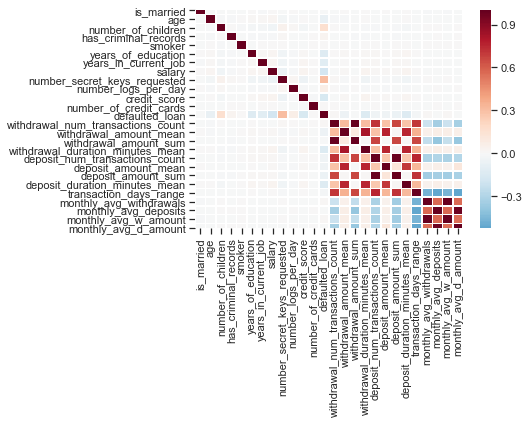

In [342]:
# Calculate the correlation matrix
corr = data["train"]["merged_train"].corr()

# plot the heatmap
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            linewidths=.5, annot = False,
            cmap="RdBu_r", center = 0)


The columns with PCC greater than 0.9 (high colinearity) are:

In [343]:
for i in range(len(corr)):
    for col in corr.columns:
        if (corr.loc[corr.index[i], col] >= 0.9) & (corr.index[i] != col):
            print("Column " + col + " and column " + str(corr.index[i]) + " have a PCC of: " + str(corr.loc[corr.index[i], col]))


Column withdrawal_amount_sum and column withdrawal_num_transactions_count have a PCC of: 0.9923256642366236
Column withdrawal_num_transactions_count and column withdrawal_amount_sum have a PCC of: 0.9923256642366236
Column deposit_amount_sum and column deposit_num_transactions_count have a PCC of: 0.9871532956065732
Column deposit_num_transactions_count and column deposit_amount_sum have a PCC of: 0.9871532956065732
Column monthly_avg_w_amount and column monthly_avg_withdrawals have a PCC of: 0.9948569881941388
Column monthly_avg_d_amount and column monthly_avg_deposits have a PCC of: 0.9810751704772432
Column monthly_avg_withdrawals and column monthly_avg_w_amount have a PCC of: 0.9948569881941388
Column monthly_avg_deposits and column monthly_avg_d_amount have a PCC of: 0.9810751704772432


We can combine or remove one of the highly colinear numerical columns, we will opt for the second:

In [344]:
columns_to_drop = ["withdrawal_amount_sum", "deposit_amount_sum", "monthly_avg_w_amount", "monthly_avg_d_amount"]
            
eda_df = eda_df.drop(columns_to_drop, axis = 1)
data["train"]["merged_train"] = data["train"]["merged_train"].drop(columns_to_drop, axis = 1)
data["test"]["merged_test"] = data["test"]["merged_test"].drop(columns_to_drop, axis = 1)

num_cols = [col for col in num_cols if col not in ["withdrawal_amount_sum", "deposit_amount_sum", "monthly_avg_w_amount", "monthly_avg_d_amount"]]


After removing one of both we are left with the following numerical columns:

In [345]:
for col in num_cols:
    print("* " + col)

* age
* number_of_children
* years_of_education
* years_in_current_job
* salary
* number_secret_keys_requested
* number_logs_per_day
* credit_score
* number_of_credit_cards
* withdrawal_num_transactions_count
* withdrawal_amount_mean
* withdrawal_duration_minutes_mean
* deposit_num_transactions_count
* deposit_amount_mean
* deposit_duration_minutes_mean
* transaction_days_range
* monthly_avg_withdrawals
* monthly_avg_deposits


### 2) Plotting pairplots

For simplicity I will only plot the first 5 numerical columns.


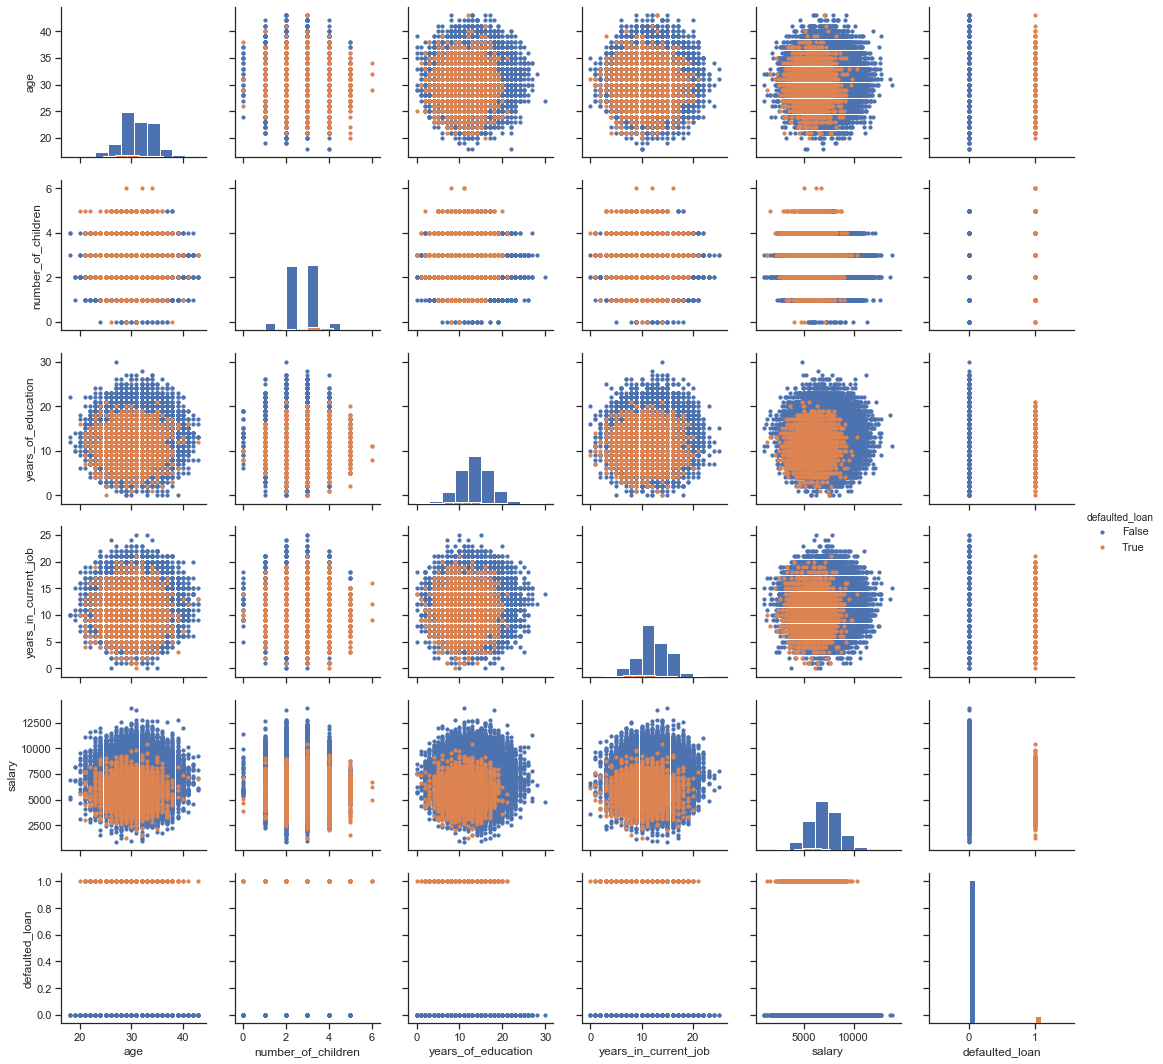

In [346]:
g = sns.PairGrid(eda_df[num_cols[0:5] +["defaulted_loan"]], hue = "defaulted_loan")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, s = 10)
g.add_legend()
plt.show()

From the past plots we may further analyze, for example, the number_of_children vs salary scatterplot and the years_of_education vs salary scatterplots.

**Note**

- For the two following plots I introduced some "jitter" along the x axis to better visualize them.

#### *number_of_children* vs *salary* scatterplot

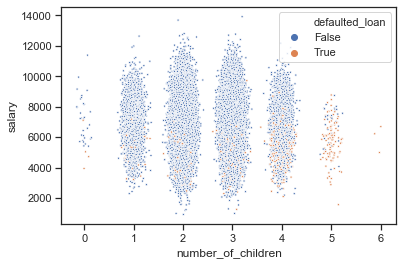

In [347]:
alt_eda_df = eda_df.copy()
alt_eda_df.number_of_children = alt_eda_df.number_of_children + np.random.randn(len(eda_df))/10  #Jittering number_of_children values 
sns.scatterplot(data = alt_eda_df, x = "number_of_children", y = "salary", hue ="defaulted_loan",  alpha=1, s = 5)
plt.show()


From the plot above we can notice a tendency from people who defaulted loan to have more children combined with lesser salary


#### *years_of_education* vs *salary* scatterplot

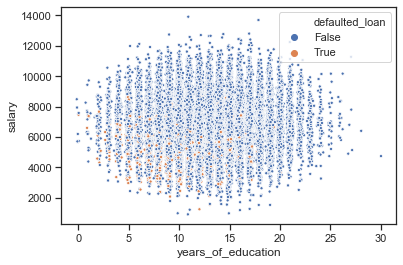

In [348]:
alt_eda_df = eda_df.copy()
alt_eda_df.years_of_education = alt_eda_df.years_of_education + np.random.randn(len(eda_df))/8  #Jittering years_of_education values
sns.scatterplot(data = alt_eda_df, x = "years_of_education", y = "salary", hue ="defaulted_loan",  alpha= 1, s = 10)
plt.show()

From the plot above we can notice a tendency from people who defaulted loan to have less years of education combined with lesser salary

# Feature extraction after Exploratory Data Analysis (EDA)

A well designed EDA may lead us to the creation of relevant features.

The goal of this section is to example the implementation of two features derived from EDA:
* salary_per_child : Salary per child (float32)
* years_of_education_per_salaryr : Years of education divided by salary (float32). The goal of this metric is to measure the hypothetical "ROI" of every year o education.


In [349]:
def feat_eng2(df):
    df["salary_per_child"] = df.salary/df.number_of_children
    df.loc[df.number_of_children == 0, "salary_per_child"] = df.loc[df.number_of_children == 0, "salary"]*1.20
    df["years_of_education_per_salary"] = df.years_of_education/df.salary
    return df

for dataset in ["train", "test"]:    
    data[dataset]["merged_" + dataset] = feat_eng2(data[dataset]["merged_" + dataset])

# Building and comparing models performance

Choosing a model depends of the goals of implementation. In this case, the tradeoff between identifying more defaulted loans at the cost of misclassification can be analyzed with a specific tool called a roc curve. 

When the model predicts a class label, a probability threshold is used to make the decision. This threshold is set by default at 50% so that observations with more than a 50% chance of membership belong to one class and vice-versa.

ROC curves allow us to see the impact of varying this voting threshold by plotting the true positive prediction rate against the false positive prediction rate for each threshold value between 0% and 100%.

The area under the ROC curve (AUC) quantifies the model’s ability to distinguish between delinquent and non-delinquent observations. A completely useless model will have an AUC of .5 as the probability for each event is equal. A perfect model will have an AUC of 1 as it is able to perfectly predict each class.

Altough we will plot AUC of the models, **we will use the recall metric (with a threshold of 0.5) to select the best model**.

## Generating pre-model train and test sets

In [350]:
cat_cols = []
bool_cols = []
num_cols = []
date_cols = []

for x in data["train"]["merged_train"].columns:
    if x != "client_id":
        if data["train"]["merged_train"][x].dtypes in ["object"]:
            cat_cols.append(x)
        elif data["train"]["merged_train"][x].dtypes in ["bool"]:
            bool_cols.append(x)
        elif data["train"]["merged_train"][x].dtypes in ["int64", "float64"]:
            num_cols.append(x)
        else:
            date_cols.append(x)

features = cat_cols + bool_cols + num_cols
label = "defaulted_loan"

trainset = data["train"]["merged_train"][features]
testset = data["test"]["merged_test"][[x for x in features if x != label]]


## Redefining trainset and devset

It is necessary to train the model by measuring it's performance on not seen data (usually called dev set).
We will assign 80% of the original train set data to our newly defined train set and the rest of 20% data to the dev set.


In [351]:
# Shuffle train set
x, y = shuffle(trainset.drop([label], axis = 1), trainset[label])

# Assign 80% data to train set 20% data to dev set
x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size = 0.2)


## Defining data wrangling transformers

### 1) Null values Imputing

Imputing is made to fill missing values with diverse techniques.
Theres no need to do imputing as the trainset and testset do not contain missing values.

### 2) Standard Scaler for numerical columns

Standard scaling features helps linear models converge faster.

In [352]:
scaler = StandardScaler()

### 3) Onehot Encoder for categorical columns

A lot of models do not accept strings as input. One hot encoding turns categorical columns into dummy encoded columns.

In [353]:
ohe = OneHotEncoder(handle_unknown = 'ignore')

## Transforming train and test data with defined wrangling pipeline steps

We use data wrangling transformers previously defined to transform data into the input of ML models.

In [354]:
dwr_pipe = ColumnTransformer([("scaler", scaler, num_cols), ("ohe", ohe, cat_cols)],
                             remainder = "passthrough", sparse_threshold = 0, n_jobs = -1)

dwr_model = dwr_pipe.fit(x)
x_train = dwr_model.transform(x_train) # Transformed trainset
x_dev = dwr_model.transform(x_dev)
x_test = dwr_model.transform(testset)

## Oversampling trainset

We can notice that our dataset's label to predict has imbalanced data because only a small fraction of observations are actually positives (the same is true if only a small fraction of observations were negatives). 

Recently, oversampling the minority class observations has become a common approach to improve the quality of predictive modeling. By oversampling, models are sometimes better able to learn patterns that differentiate classes. [3]


In [355]:
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

## Building ML models

In this section we build ML models with changing hyperparameters. The goal is to find the model which better fits our needs.

### 1) Logistic Regression Model pipeline

In [356]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import itertools

def param_grid_l(params):
    lr = LogisticRegression(penalty = params[0], C = params[1], max_iter = 1000)
    lr_model = lr.fit(x_train, y_train)
    lr_y_pred = lr_model.predict_proba(x_dev)
    auc = roc_auc_score(y_dev, pd.DataFrame(lr_y_pred)[1])
    return (lr, auc, lr_y_pred, params)

penalty = ['l2']
C = [0.01, 0.1, 1, 10]
param_iter = list(itertools.product(penalty, C))
lr_models =  [param_grid_l(params) for params in param_iter]

C:\Users\enriq\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 2) Random Forest Model pipeline

In [357]:
def param_grid_rf(params):
    rf = RandomForestClassifier(n_estimators = params[0], max_depth = params[1])
    rf_model = rf.fit(x_train, y_train)
    rf_y_pred = rf_model.predict_proba(x_dev)
    
    return (rf, auc, rf_y_pred, params)

n_estimators = [25, 50, 70]
max_depth = [25, 50, 75]
param_iter = list(itertools.product(n_estimators, max_depth))
rf_models =  [param_grid_rf(params) for params in param_iter]

## Ploting ROC curves for each model

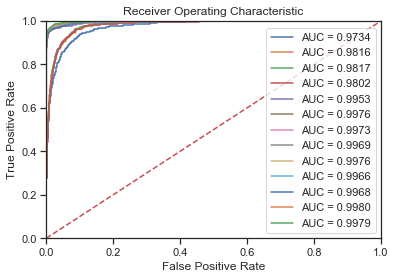

In [358]:
from sklearn.metrics import recall_score

models = lr_results + rf_results
recalls = []
aucs = []

plt.title('Receiver Operating Characteristic')
for model in models:
    y_pred_proba = model[0].predict_proba(x_dev)
    y_pred = model[0].predict(x_dev)
    auc = roc_auc_score(y_dev, pd.DataFrame(y_pred_proba)[1])
    recall = recall_score(y_dev, y_pred)
    fpr, tpr, threshold = roc_curve(y_dev, pd.DataFrame(y_pred_proba)[1])
    recalls.append(recall)
    aucs.append(auc)
    plt.plot(fpr, tpr, label = 'AUC = %0.4f' % auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [359]:
best_auc_model = models[np.argmax(aucs)][0]
print("The model with max auc is : " + str(best_auc_model), end = "\n\n")
print("With a AUC of " + str(aucs[np.argmax(aucs)]))
print("With a Recall of " + str(recalls[np.argmax(aucs)]))

The model with max auc is : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

With a AUC of 0.9980328379310925
With a Recall of 0.8912429378531074


In [360]:
best_recall_model = models[np.argmax(recalls)][0]
print("The model with max recall is : " + str(best_recall_model), end = "\n\n")
print("With a AUC of " + str(aucs[np.argmax(recalls)]))
print("With a Recall of " + str(recalls[np.argmax(recalls)]))

The model with max recall is : LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

With a AUC of 0.9815634323317828
With a Recall of 0.9209039548022598


As we can see, the model with the highest AUC is not always the model that interests us. The model that we will select to make predictions will be the one with the highest **Recall**

In [361]:
best_model = best_recall_model

# Error analysis

In this section we further explore the instances in which the model made a wrong prediction to try to find patters, generate model improval propositions and estimate the (time investment)/(reward) ratio of each to take a decision of the next step to perform improvement in the model.

In [362]:
# Had no time to do it :C

# ELI5

ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions.

Ideas of why is explaining predictions important are discussed in more depth in the paper 'Why Should I Trust You?: Explaining the Predictions of Any Classifier' by Marco Tulio Ribeiro, et. al [5]

This section is meant to work as an example of an effort to do explain model's predictions better.

In [363]:
display(eli5.show_weights(best_model))

Weight?,Feature
+8.592,x824
+1.588,x811
+1.536,x458
+1.463,x257
+1.423,x681
+1.390,x815
+1.335,x819
+1.310,x699
+1.240,x816
+1.226,x818


In [364]:
print("Explaining a prediction of a single client.")
display(eli5.show_prediction(best_recall_model, x_train[1]))

Explaining a prediction of a single client.


# Generating final output CSV

In [365]:
y_test = best_model.predict(x_test)
output = pd.DataFrame(y_test, columns = ["defaulted_loan"])
output["client_id"] = data["test"]["merged_test"]["client_id"]
output.head()

,defaulted_loan,client_id
0,True,VLCO8303182181894
1,False,RBBZ3079011934087
2,False,TKMW7833478952979
3,False,EDVH7318610024923
4,False,LRZC3795050474041


In [368]:
# Export as CSV
output.to_csv('ds_challenge_luis_garcia.csv', index = False)

# Final notes

The data science process is a cicle, although there are many opportunities for improvement, it is even more important to have a viable initial product in the shortest possible time.


# References:

[1] https://towardsdatascience.com/predicting-loan-repayment-5df4e0023e92

[2] https://stats.stackexchange.com/questions/146907/principled-way-of-collapsing-categorical-variables-with-many-levels

[3] https://beckernick.github.io/oversampling-modeling/

[4] https://riskspan.com/news-insight-blog/hands-on-machine-learning-predicting-loan-delinquency/

[5] https://arxiv.org/pdf/1602.04938.pdf